In [103]:
# import
import cv2
import pickle
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from glob import glob
from tqdm.notebook import trange
from numba import jit
from pprint import pprint
from joblib import Parallel, delayed
from sklearn import svm, neural_network, cluster
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler

# カメラを起動する
camera = cv2.VideoCapture(0)
CAMERA_SIZE = (50, 85)  # 取得した写真はこのサイズに縮小する

# ライントレースの行動クラス番号
LEFT_ACTCODE = 0
RIGHT_ACTCODE = 1
LEFT90_ACTCODE = 2
RIGHT90_ACTCODE = 3
STRAIGHT_ACTCODE = 4

print("OpenCV", cv2.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("Pyautogui", pg.__version__)
print("Scikit-learn", sklearn.__version__)


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


OpenCV 4.5.4
numpy 1.20.1
pandas 1.2.4
Pyautogui 0.9.53
Scikit-learn 0.24.1


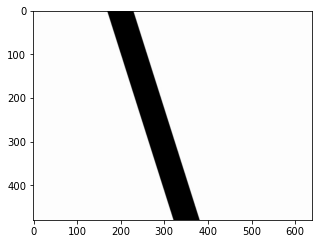

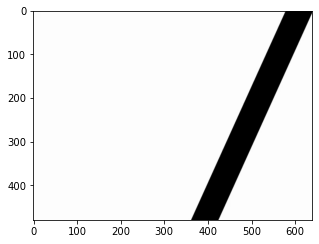

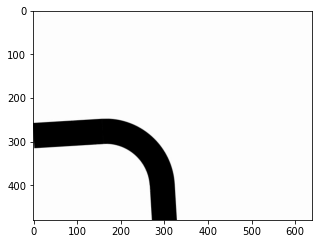

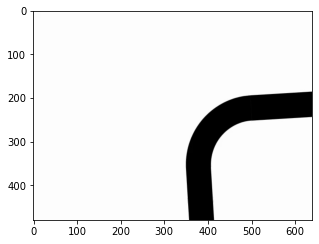

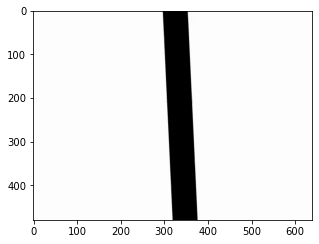

In [104]:
# タイルのサンプルを集める
# タイルのサンプルを集める (左に曲がる)
Left_videoPath = "C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/left_vid.mp4"

vid = cv2.VideoCapture(Left_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)

# タイルのサンプルを集める (右に曲がる)
Right_videoPath = "C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/right_vid.mp4"

vid = cv2.VideoCapture(Right_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)

# タイルのサンプルを集める (90度に左に曲がる)
Left90_videoPath = "C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/left90_vid.mp4"

vid = cv2.VideoCapture(Left90_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)

# タイルのサンプルを集める (90度に右に曲がる)
Right90_videoPath = "C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/right90_vid.mp4"

vid = cv2.VideoCapture(Right90_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)

# タイルのサンプルを集める (真っ直ぐ進む)
Straight_videoPath = "C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/generated/video/stright_vid.mp4"

vid = cv2.VideoCapture(Straight_videoPath)

ret, frame = vid.read()
if ret:
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig = plt.figure(1, (5., 5.))
    plt.imshow(img)
    plt.pause(0.1)


In [105]:
OFFSET_CHECK_EXIST_BLACK = 12
BLACK_COUNT = 3

col_model = LoadInstances("ColorReco2.pickle")


def analyzer(raw_frame):
    global col_model
    #
    frame = cv2.resize(raw_frame, (64, 36))
    height, width = frame.shape[:2]
    #
    # 色を識別する
    recognized_frame = np.flipud(
        np.reshape(
            col_model.predict(np.reshape(frame, (-1, 3))),
            np.shape(frame)[:2]
        )
    )
    #
    # 画面上部と画面下部における黒の総量
    temp_frame_height_middle = math.floor(len(recognized_frame) / 2)
    black_amount_bottom = np.sum(np.where(recognized_frame[:temp_frame_height_middle, :] == 1, 1, 0))
    black_amount_upper = np.sum(np.where(recognized_frame[temp_frame_height_middle:, :] == 1, 1, 0))
    #
    # 画像縦列における黒の出現割合
    black_distribution_weighted_bottom = np.sum(np.array(np.where(recognized_frame == 1, 1, 0)) *
                                                np.reshape(np.arange(len(recognized_frame), 0, -1), (-1, 1)), axis=0)
    black_distribution_weighted_upper = np.sum(np.array(np.where(recognized_frame == 1, 1, 0)) *
                                               np.reshape(np.arange(0, len(recognized_frame), 1), (-1, 1)), axis=0)
    #
    # 画像縦列における黒の出現位置の中心インデックス
    black_center_position_weighted_bottom = np.round((np.sum(black_distribution_weighted_bottom * np.arange(
        0, len(black_distribution_weighted_bottom), 1))) / np.sum(black_distribution_weighted_bottom) / width - 0.5, 2) * 100
    black_center_position_weighted_upper = np.round((np.sum(black_distribution_weighted_upper * np.arange(0,
                                                    len(black_distribution_weighted_upper), 1))) / np.sum(black_distribution_weighted_upper) / width - 0.5, 2) * 100
    #
    # 画像全体における赤の出現インデックスを抽出
    raw_red_appeared = np.where(recognized_frame == 3)
    red_appeared = np.hstack((np.reshape(raw_red_appeared[0], (-1, 1)), np.reshape(raw_red_appeared[1], (-1, 1))))  # ["height", "width"]
    occupy_red_appeared = np.round(len(red_appeared) / (height * width), 2)
    #
    # 画像全体における緑の出現インデックスを抽出
    is_green_found = len(np.where(recognized_frame == 2)[0]) > 4
    if is_green_found:
        # 緑の周囲に黒が存在するかを確認するための配列を作る
        temp_recognized_frame = np.zeros_like(recognized_frame)
        temp_enabled_zone = np.s_[:OFFSET_CHECK_EXIST_BLACK * -1, OFFSET_CHECK_EXIST_BLACK:OFFSET_CHECK_EXIST_BLACK * -1]
        temp_recognized_frame[temp_enabled_zone] = recognized_frame[temp_enabled_zone]
        #
        # 緑色であるピクセルの位置インデックス
        temp_green_appeared = np.where(temp_recognized_frame == 2)
        green_appeared = (
            np.hstack((np.reshape(temp_green_appeared[0], (-1, 1)), np.reshape(temp_green_appeared[1], (-1, 1)))))  # ["height", "width"]
        #
        if len(green_appeared) > 4:
            # 緑色のピクセルインデックスを４つに絞り込む
            green_KMeans_center = np.array(cluster.MiniBatchKMeans(n_clusters=4).fit(green_appeared).cluster_centers_).astype(np.int16)
            #
            # 全体に占める緑色の割合
            occupy_green_appeared = np.round(len(green_appeared) / (height * width), 2)
            #
            green_cluster_around = np.zeros((1, 3))
            for i in range(len(green_KMeans_center)):
                x = green_KMeans_center[i, 0]
                y = green_KMeans_center[i, 1]
                of = OFFSET_CHECK_EXIST_BLACK
                ones = np.ones(OFFSET_CHECK_EXIST_BLACK).astype(np.int16)
                upper = np.sum(np.where(recognized_frame == 1, 1, 0)[np.arange(x, x + of, 1), ones * y])
                right = np.sum(np.where(recognized_frame == 1, 1, 0)[ones * x, np.arange(y, y + of, 1)])
                left = np.sum(np.where(recognized_frame == 1, 1, 0)[ones * x, np.arange(y, y - of, -1)])
                green_cluster_around = np.append(green_cluster_around, [[left, upper, right]], axis=0)
                # @for anchor
            green_cluster_around = np.round(green_cluster_around[1:, :], 2)
            temp = np.where(green_cluster_around[1] >= BLACK_COUNT)
            is_this_meant_right = True in (green_cluster_around[temp, 0] >= BLACK_COUNT)
            is_this_meant_left = True in (green_cluster_around[temp, 2] >= BLACK_COUNT)
            is_this_meant_turn = is_this_meant_right and is_this_meant_left   # is_this_meant_left and is_this_meant_right
    else:
        # タイルに緑色がない
        occupy_green_appeared = 0.0
        is_this_meant_right = False
        is_this_meant_left = False
        is_this_meant_turn = False
    #
    # 表示
    return [
        black_amount_bottom / (64 * 36 / 2),
        black_amount_upper / (64 * 36 / 2),
        black_center_position_weighted_bottom / 64,
        black_center_position_weighted_upper / 64,
        occupy_green_appeared,
        occupy_red_appeared,
        is_this_meant_right,
        is_this_meant_left,
        is_this_meant_turn
    ]


100%|██████████| 6160/6160 [00:00<00:00, 11437.90it/s]
C:\Users\Haya\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


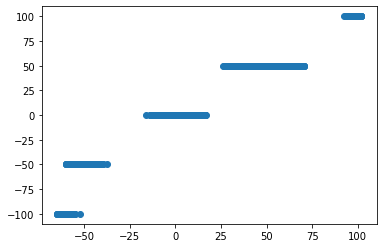

[15.48226323]


C:\Users\Haya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


ValueError: 4 is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

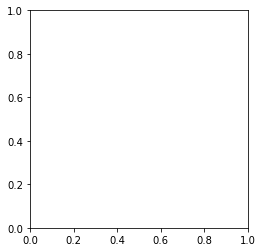

In [106]:
# ライントレースの判断モデルを作る (線形サポートベクトル回帰モデル)

pathList = [
    # それぞれの行動パターンに番号を振り与える
    [Left_videoPath, 50],
    [Right_videoPath, -50],
    [Left90_videoPath, 100],
    [Right90_videoPath, -100],
    [Straight_videoPath, 0],
]

allOf_samples = np.empty(shape=0)

for pl in pathList:
    path = pl[0]
    how_act = pl[1]
    vid = cv2.VideoCapture(path)
    frame_count = math.floor(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    count = 0
    for f in tqdm(range(frame_count)):
        count += 1
        if count % 10 == 0:
            ret, raw_frame = vid.read()
            res = analyzer(raw_frame)
            res = np.append(res, how_act)
            allOf_samples = np.append(allOf_samples,res)

allOf_samples = np.reshape(allOf_samples,newshape=(-1, len(res)))

X_train, X_test, y_train, y_test = train_test_split(
    allOf_samples[:, :-1],
    allOf_samples[:, -1:],
    stratify=allOf_samples[:, -1:],  # テストに使うデータを階層化する
    test_size=0.3,  # テストに使う割合
)

model = svm.SVR().fit(X_train, y_train)

plt.scatter(np.ravel(model.predict(X_test)),np.ravel(y_test))
plt.show()

for path in glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/part/*"):
    frame = cv2.imread(path)
    res = analyzer(frame)
    print(model.predict([res]))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()